# LoRA fine-tunning for Stable Diffusion

Basado en el trabajo de [Hollowstrawberry](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Spanish_Lora_Trainer.ipynb), [Kohya_ss](https://github.com/kohya-ss/sd-scripts) y [Linaqruf](https://colab.research.google.com/github/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-dreambooth.ipynb#scrollTo=-Z4w3lfFKLjr)

In [ ]:
# ========== Reporte ==========
from datetime import datetime
import time
process_start = datetime.now()
time_start = time.time()
report = (
    f"Reporte Fine tunning Stable Diffusion mediante LoRA\n"
    f"----------------------------------------------------------------\n"
    f"Inicio del proceso: {process_start} \n"
)

In [ ]:
# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
conf_start_time = time.time()
report += f": {datetime.now()} -- Comienza la configuración del entorno de ejecución\n"

In [ ]:
import os
import re
import toml
import shutil
import zipfile
from time import time
from IPython.display import Markdown, display

# These carry information from past executions
if "model_url" in globals():
  old_model_url = model_url
else:
  old_model_url = None
if "dependencies_installed" not in globals():
  dependencies_installed = False
if "model_file" not in globals():
  model_file = None

# These may be set by other cells, some are legacy
if "custom_dataset" not in globals():
  custom_dataset = None
if "override_dataset_config_file" not in globals():
  override_dataset_config_file = None
if "override_config_file" not in globals():
  override_config_file = None
if "optimizer" not in globals():
  optimizer = "AdamW8bit"
if "optimizer_args" not in globals():
  optimizer_args = None
if "continue_from_lora" not in globals():
  continue_from_lora = ""
if "weighted_captions" not in globals():
  weighted_captions = False
if "adjust_tags" not in globals():
  adjust_tags = False
if "keep_tokens_weight" not in globals():
  keep_tokens_weight = 1.0

COLAB = True # low ram
XFORMERS = False
SOURCE = "https://github.com/uYouUs/sd-scripts"
COMMIT = None
BETTER_EPOCH_NAMES = True
LOAD_TRUNCATED_IMAGES = True

In [ ]:
#@markdown ### ▶️ Base
#@markdown El nombre de tu proyecto también es el nombre de la carpeta donde irán tus imágenes. No se permiten espacios.
nombre_proyecto = "zapatillasLoRA" #@param {type:"string"}
project_name = nombre_proyecto.strip()
#@markdown La estructura de carpetas no importa y es por comodidad. Asegúrate de siempre elegir la misma.
estructura_de_carpetas = "Organizar por proyecto (/Loras/nombre_proyecto/dataset)"
folder_structure = estructura_de_carpetas

In [ ]:
root_dir = "/content" if COLAB else "~/Loras"
deps_dir = os.path.join(root_dir, "deps")
repo_dir = os.path.join(root_dir, "kohya-trainer")
print("root_dir: " + root_dir)
print("deps_dir: " + deps_dir)
print("repo_dir: " + repo_dir)

root_dir: /content
deps_dir: /content/deps
repo_dir: /content/kohya-trainer


In [ ]:
if "/Loras" in folder_structure:
  # main_dir      = os.path.join(root_dir, "drive/MyDrive/Loras") if COLAB else root_dir
  main_dir      = os.path.join(root_dir, "/content/Loras/") if COLAB else root_dir
  log_folder    = os.path.join(main_dir, "_logs")
  config_folder = os.path.join(main_dir, project_name)
  images_folder = os.path.join(main_dir, project_name, "dataset")
  output_folder = os.path.join(main_dir, project_name, "output")
else:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/lora_training") if COLAB else root_dir
  images_folder = os.path.join(main_dir, "datasets", project_name)
  output_folder = os.path.join(main_dir, "output", project_name)
  config_folder = os.path.join(main_dir, "config", project_name)
  log_folder    = os.path.join(main_dir, "log")

config_file = os.path.join(config_folder, "training_config.toml")
dataset_config_file = os.path.join(config_folder, "dataset_config.toml")
accelerate_config_file = os.path.join(repo_dir, "accelerate_config/config.yaml")

print("main_dir: " + main_dir)
print("log_folder: " + log_folder)
print("config_file: " + config_file)
print("dataset_config_file: " + dataset_config_file)
print("accelerate_config_file: " + accelerate_config_file)

main_dir: /content/Loras/
log_folder: /content/Loras/_logs
config_file: /content/Loras/zapatillasLoRA/training_config.toml
dataset_config_file: /content/Loras/zapatillasLoRA/dataset_config.toml
accelerate_config_file: /content/kohya-trainer/accelerate_config/config.yaml


## Install dependencies

In [ ]:
# def install_dependencies():
!git clone {SOURCE} {repo_dir}
os.chdir(repo_dir)

if COMMIT:
  !git reset --hard {COMMIT}

!wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/train_network_wrapper.py -q -O train_network_wrapper.py
!wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/dracula.py -q -O dracula.py
!wget https://raw.githubusercontent.com/sgonzalezgg/sd-finetuning-comparison/main/lora/train_network.py -O /content/kohya-trainer/train_network.py

Cloning into '/content/kohya-trainer'...
remote: Enumerating objects: 7040, done.
remote: Total 7040 (delta 0), reused 0 (delta 0), pack-reused 7040 (from 1)
Receiving objects: 100% (7040/7040), 9.88 MiB | 9.00 MiB/s, done.
Resolving deltas: 100% (5065/5065), done.
--2025-06-09 20:32:17--  https://raw.githubusercontent.com/sgonzalezgg/sd-finetuning-comparison/main/lora/train_network.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62273 (61K) [text/plain]
Saving to: ‘/content/kohya-trainer/train_network.py’

/content/kohya-trai 100%[===================>]  60.81K  --.-KB/s    in 0.02s   

2025-06-09 20:32:17 (3.76 MB/s) - ‘/content/kohya-trainer/train_network.py’ saved [62273/62273]



In [ ]:
!apt -y update -qq
!apt -y install aria2 -qq

42 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
S

In [ ]:
# requirements_path = "/content/drive/MyDrive/UNIR/TFM/DREAMB/requirements.txt"
requirements_path = "https://github.com/sgonzalezgg/sd-finetuning-comparison/raw/main/lora/requirements.txt"

!pip install -r "{requirements_path}"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 768.5/768.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.3/484.3 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# !pip install -e .
if XFORMERS:
  !pip install xformers==0.0.28.post1

# patch kohya for minor stuff
if COLAB:
  !sed -i "s@cpu@cuda@" library/model_util.py # low ram
if LOAD_TRUNCATED_IMAGES:
  !sed -i 's/from PIL import Image/from PIL import Image, ImageFile\nImageFile.LOAD_TRUNCATED_IMAGES=True/g' library/train_util.py # fix truncated jpegs error
if BETTER_EPOCH_NAMES:
  !sed -i 's/{:06d}/{:02d}/g' library/train_util.py # make epoch names shorter
  !sed -i 's/"." + args.save_model_as)/"-{:02d}.".format(num_train_epochs) + args.save_model_as)/g' train_network.py # name of the last epoch will match the rest

from accelerate.utils import write_basic_config
if not os.path.exists(accelerate_config_file):
  write_basic_config(save_location=accelerate_config_file)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["BITSANDBYTES_NOWELCOME"] = "1"
os.environ["SAFETENSORS_FAST_GPU"] = "1"

In [ ]:
import time
report += f"Configuración completada. Tiempo empleado en establecer la configuración inicial: {time.time() - conf_start_time} segundos.\n"
report += f"----------------------------------------------------------------\n"

In [ ]:
load_start_time = time.time()
report += f": {datetime.now()} -- Comienza la configuración relativa al nuevo concepto y modelo a entrenar\n"

In [ ]:
# Se trae mis imagenes y captions de github a una carpeta en colab
import os
from pathlib import Path

# Ruta local donde guardarás los datos
path_concept = "/content/Loras/zapatillasLoRA/dataset"
data_root = Path(path_concept)
data_root.mkdir(parents=True, exist_ok=True)

# Lista de imágenes y captions
files = ["zapatilla_1.JPEG", "zapatilla_1.txt",
         "zapatilla_2.JPEG", "zapatilla_2.txt",
         "zapatilla_3.JPEG", "zapatilla_3.txt",
         "zapatilla_4.JPEG", "zapatilla_4.txt",
         "zapatilla_5.JPEG", "zapatilla_5.txt",
         "zapatilla_9.JPEG", "zapatilla_9.txt",
         "zapatilla_10.JPEG", "zapatilla_10.txt",
         "zapatilla_11.JPEG", "zapatilla_11.txt",
         "zapatilla_12.JPEG", "zapatilla_12.txt",
         "zapatilla_13.JPEG", "zapatilla_13.txt",
         "zapatilla_14.JPEG", "zapatilla_14.txt",
         "zapatilla_15.JPEG", "zapatilla_15.txt",
         "zapatilla_16.JPEG", "zapatilla_16.txt",
         "zapatilla_17.JPEG", "zapatilla_17.txt",
         "zapatilla_19.JPEG", "zapatilla_19.txt",
         "zapatilla_20.JPEG", "zapatilla_20.txt",
         "zapatilla_21.JPEG", "zapatilla_21.txt",
         "zapatilla_22.JPEG", "zapatilla_22.txt",
         "zapatilla_23.JPEG", "zapatilla_23.txt",
         "zapatilla_24.JPEG", "zapatilla_24.txt",
         "zapatilla_25.JPEG", "zapatilla_25.txt",
         "zapatilla_26.JPEG", "zapatilla_26.txt",
         "zapatilla_27.JPEG", "zapatilla_27.txt",
         "zapatilla_29.JPEG", "zapatilla_29.txt",
         "zapatilla_30.JPEG", "zapatilla_30.txt",
         "zapatilla_31.jpg", "zapatilla_31.txt",
         "zapatilla_32.jpg", "zapatilla_32.txt",
         "zapatilla_33.jpg", "zapatilla_33.txt",
         "zapatilla_35.JPG", "zapatilla_35.txt",
         "zapatilla_36.jpg", "zapatilla_36.txt"
         ]

# Descargar desde GitHub
base_url = "https://github.com/sgonzalezgg/sd-finetuning-comparison/raw/main/data/concept_data/"
for file in files:
    url = base_url + file
    os.system(f"wget -q {url} -P {data_root}")

In [ ]:
#@title ## Configuración
#@markdown Decidir el modelo base de entrenamiento. Los modelos por defecto producen los resultados más limpios y consistentes. Puedes cambiarlo por un modelo propio si lo deseas.
modelo_de_entrenamiento = "Stable Diffusion (sd-v1-5-pruned-noema-fp16.safetensors)" #@param ["Anime (animefull-final-pruned-fp16.safetensors)", "AnyLora (AnyLoRA_noVae_fp16-pruned.ckpt)", "Stable Diffusion (sd-v1-5-pruned-noema-fp16.safetensors)"]
opcional_enlace_a_modelo_propio = "" #param {type:"string"}
modelo_propio_basado_en_sd2 = False #param {type:"boolean"}
custom_model_is_based_on_sd2 = modelo_propio_basado_en_sd2

if opcional_enlace_a_modelo_propio:
  model_url = opcional_enlace_a_modelo_propio
elif "AnyLora" in modelo_de_entrenamiento:
  model_url = "https://huggingface.co/Lykon/AnyLoRA/resolve/main/AnyLoRA_noVae_fp16-pruned.ckpt"
elif "Anime" in modelo_de_entrenamiento:
  model_url = "https://huggingface.co/hollowstrawberry/stable-diffusion-guide/resolve/main/models/animefull-final-pruned-fp16.safetensors"
else:
  model_url = "https://huggingface.co/hollowstrawberry/stable-diffusion-guide/resolve/main/models/sd-v1-5-pruned-noema-fp16.safetensors"

#@markdown ### ▶️ Procesamiento <p>
#@markdown La resolución de 512 es estándar en Stable Diffusion 1.5. No es necesario recortar o achicar, el proceso es automático.
resolucion = 512 #@param {type:"slider", min:512, max:1024, step:128}
resolution = resolucion
#@markdown Esta opción va a voltear tus imágenes para así tener el doble y aprender mejor. <p>
#@markdown **Desactiva esto si te importan los elementos asimétricos en tu Lora.**
flip_aug = True #@param {type:"boolean"}
#markdown Leave empty for no captions.
caption_extension = ".txt" #param {type:"string"}
#@markdown Mezclar las tags de anime ayuda al aprendizaje. Una tag de activación va al inicio de cada archivo de texto y no se mezclará.
mezclar_tags = False #@param {type:"boolean"}
shuffle_caption = mezclar_tags
tags_de_activacion = "0" #@param [0,1,2,3]
keep_tokens = int(tags_de_activacion)

#@markdown ### ▶️ Pasos <p>
#@markdown Tus imágenes se repetirán este número de veces durante el entrenamiento. Recomiendo que el valor total sea entre 200 y 400.
num_repeats = 10 #@param {type:"number"}
#@markdown Cuánto tiempo deseas entrenar. Un buen punto de partida puede ser alrededor de 10 epochs o alrededor de 2000 pasos. <p>
#@markdown Un epoch es una cantidad de pasos igual a: tu cantidad de imágenes multipliccada por sus repeticiones, y dividido en el batch size.
unidad_preferida = "Epochs" #@param ["Epochs", "Pasos"]
cuantos = 6 #@param {type:"number"}
max_train_epochs = cuantos if unidad_preferida == "Epochs" else None
max_train_steps = cuantos if unidad_preferida == "Pasos" else None
#@markdown Guardar más epochs te permitirá comparar mejor el progreso de tu Lora.
guardar_cada_cuantos_epochs = 1 #@param {type:"number"}
save_every_n_epochs = guardar_cada_cuantos_epochs
guardar_solo_ultimos_epochs = 6 #@param {type:"number"}
keep_only_last_n_epochs = guardar_solo_ultimos_epochs
if not save_every_n_epochs:
  save_every_n_epochs = max_train_epochs
if not keep_only_last_n_epochs:
  keep_only_last_n_epochs = max_train_epochs
#@markdown Un batch size mayor hace el entrenamiento más rápido, pero puede empeorar el aprendizaje. Se recomienda 2 o 3.
batch_size = 1 #@param {type:"slider", min:1, max:8, step:1}
train_batch_size = batch_size

#@markdown ### ▶️ Aprendizaje
#@markdown La tasa de aprendizaje es lo más importante. Si deseas entrenar más lento con muchas imágenes, o si tienes un dim y alpha altos, usa un unet de 2e-4 o menor. <p>
#@markdown El text encoder ayuda a tu Lora a aprender conceptos un poco mejor. Se recomienda la mitad o un quinto del unet. Puedes dejarlo en 0 para algunos estilos.
aprendizaje_unet = 1e-4 #@param {type:"number"}
unet_lr = aprendizaje_unet
aprendizaje_text_encoder = 2e-5 #@param {type:"number"}
text_encoder_lr = aprendizaje_text_encoder
#@markdown El scheduler es el algoritmo matemático que guiará el entrenamiento. Para personajes recomiendo `cosine_with_restarts` con un valor de 3. Si no estás seguro ponlo en `constant` e ignora el valor.
scheduler = "cosine_with_restarts" #@param ["constant", "cosine", "cosine_with_restarts", "constant_with_warmup", "linear", "polynomial"]
lr_scheduler = scheduler
valor_de_scheduler = 3 #@param {type:"number"}
lr_scheduler_number = valor_de_scheduler
lr_scheduler_num_cycles = lr_scheduler_number if lr_scheduler == "cosine_with_restarts" else 0
lr_scheduler_power = lr_scheduler_number if lr_scheduler == "polynomial" else 0
#@markdown Pasos de calentamiento durante el entrenamiento para un inicio eficiente. Recomiendo dejarlo en 5%.
calentamiento = 0.05 #@param {type:"slider", min:0.0, max:0.5, step:0.01}
lr_warmup_ratio = calentamiento
lr_warmup_steps = 0
#@markdown Nueva función que hace el aprendizaje mucho más eficiente. Puede que tus Loras estén listos en la mitad de epochs. Se usará un valor de 5.0 como en la [investigación](https://arxiv.org/abs/2303.09556).
min_snr_gamma = True #@param {type:"boolean"}
min_snr_gamma_value = 5.0 if min_snr_gamma else None

#@markdown ### ▶️ Estructura
#@markdown LoRA es el clásico y útil para muchos usos. LoCon es bueno con estilos ya que aprende con más capas.
lora_type = "LoRA" #@param ["LoRA", "LoCon"]

#@markdown Aquí hay algunos valores recomendados para las opciones de abajo:

#@markdown | type | network_dim | network_alpha | conv_dim | conv_alpha |
#@markdown | :---: | :---: | :---: | :---: | :---: |
#@markdown | LoRA | 16 | 8 |   |   |
#@markdown | LoCon | 16 | 8 | 8 | 4 |

#@markdown Un dim mayor equivale a un Lora más grande, pero no siempre es mejor. Se recomienda de 8 a 32, con un alpha igual a la mitad del dim.
network_dim = 16 #@param {type:"slider", min:1, max:128, step:1}
network_alpha = 8 #@param {type:"slider", min:1, max:128, step:1}
#@markdown Los siguientes sólo aplican a las capas adicionales de LoCon.
conv_dim = 8 #@param {type:"slider", min:1, max:64, step:1}
conv_alpha = 4 #@param {type:"slider", min:1, max:64, step:1}

network_module = "networks.lora"
network_args = None
if lora_type.lower() == "locon":
  network_args = [f"conv_dim={conv_dim}", f"conv_alpha={conv_alpha}"]


In [ ]:
# 👩‍💻 Cool code goes here
if optimizer.lower() == "prodigy" or "dadapt" in optimizer.lower():
  if override_values_for_dadapt_and_prodigy:
    unet_lr = 0.5
    text_encoder_lr = 0.5
    lr_scheduler = "constant_with_warmup"
    lr_warmup_ratio = 0.05
    network_alpha = network_dim

  if not optimizer_args:
    optimizer_args = ["decouple=True","weight_decay=0.01","betas=[0.9,0.999]"]
    if optimizer == "Prodigy":
      optimizer_args.extend(["d_coef=2","use_bias_correction=True"])
      if lr_warmup_ratio > 0:
        optimizer_args.append("safeguard_warmup=True")
      else:
        optimizer_args.append("safeguard_warmup=False")

In [ ]:
def validate_dataset():
  global lr_warmup_steps, lr_warmup_ratio, caption_extension, keep_tokens, keep_tokens_weight, weighted_captions, adjust_tags
  supported_types = (".png", ".jpg", ".jpeg", ".webp", ".bmp")

  print("\n💿 Revisando archivos...")
  if not project_name.strip() or any(c in project_name for c in " .()\"'\\/"):
    print("💥 Error: Por favor elije un nombre de proyecto válido.")
    return

  if custom_dataset:
    try:
      datconf = toml.loads(custom_dataset)
      datasets = [d for d in datconf["datasets"][0]["subsets"]]
    except:
      print(f"💥 Error: ¡Tu configuración de datos propia es inválida o tiene errores! Por favor revisa el ejemplo original.")
      return
    reg = [d.get("image_dir") for d in datasets if d.get("is_reg", False)]
    datasets_dict = {d["image_dir"]: d["num_repeats"] for d in datasets}
    folders = datasets_dict.keys()
    files = [f for folder in folders for f in os.listdir(folder)]
    images_repeats = {folder: (len([f for f in os.listdir(folder) if f.lower().endswith(supported_types)]), datasets_dict[folder]) for folder in folders}
  else:
    reg = []
    folders = [images_folder]
    files = os.listdir(images_folder)
    images_repeats = {images_folder: (len([f for f in files if f.lower().endswith(supported_types)]), num_repeats)}

  for folder in folders:
    if not os.path.exists(folder):
      print(f"💥 Error: La carpeta {folder.replace('/content/', '')} no existe.")
      return
  for folder, (img, rep) in images_repeats.items():
    if not img:
      print(f"💥 Error: La carpeta {folder.replace('/content/', '')} está vacía.")
      return
  for f in files:
    if not f.lower().endswith((".txt", ".npz")) and not f.lower().endswith(supported_types):
      print(f"💥 Error: Archivo inválido encontrado: \"{f}\". Abortando.")
      return

  if not [txt for txt in files if txt.lower().endswith(".txt")]:
    caption_extension = ""
  if continue_from_lora and not (continue_from_lora.endswith(".safetensors") and os.path.exists(continue_from_lora)):
    print(f"💥 Error: Archivo de continuar_lora inválido. Ejemplo: /content/Loras/ejemplo.safetensors")
    return

  pre_steps_per_epoch = sum(img*rep for (img, rep) in images_repeats.values())
  steps_per_epoch = pre_steps_per_epoch/train_batch_size
  total_steps = max_train_steps or int(max_train_epochs*steps_per_epoch)
  estimated_epochs = int(total_steps/steps_per_epoch)
  lr_warmup_steps = int(total_steps*lr_warmup_ratio)

  for folder, (img, rep) in images_repeats.items():
    print("📁"+folder.replace("/content/", "") + (" (Regularización)" if folder in reg else ""))
  print(f"📈 Se encontraron {img} imágenes con {rep} repeticiones, equivalente a {img*rep} pasos.")
  print(f"📉 Divide {pre_steps_per_epoch} pasos en {train_batch_size} batch size para obtener {steps_per_epoch} pasos por epoch.")
  if max_train_epochs:
    print(f"🔮 Habrá {max_train_epochs} epochs, para un total de alrededor de {total_steps} pasos totales.")
  else:
    print(f"🔮 Habrá {total_steps} pasos, divididos en {estimated_epochs} epochs y un poco más.")

  if total_steps > 10000:
    print("💥 Error: Tus pasos totales on muy altos. Probablemente cometiste un error. Abortando...")
    return

  if adjust_tags:
    print(f"\n📎 Weighted tags: {'ON' if weighted_captions else 'OFF'}")
    if weighted_captions:
      print(f"📎 Will use {keep_tokens_weight} weight on {keep_tokens} activation tag(s)")
    print("📎 Adjusting tags...")
    adjust_weighted_tags(folders, keep_tokens, keep_tokens_weight, weighted_captions)

  return True

def adjust_weighted_tags(folders, keep_tokens: int, keep_tokens_weight: float, weighted_captions: bool):
  weighted_tag = re.compile(r"\((.+?):[.\d]+\)(,|$)")
  for folder in folders:
    for txt in [f for f in os.listdir(folder) if f.lower().endswith(".txt")]:
      with open(os.path.join(folder, txt), 'r') as f:
        content = f.read()
      # reset previous changes
      content = content.replace('\\', '')
      content = weighted_tag.sub(r'\1\2', content)
      if weighted_captions:
        # re-apply changes
        content = content.replace(r'(', r'\(').replace(r')', r'\)').replace(r':', r'\:')
        if keep_tokens_weight > 1:
          tags = [s.strip() for s in content.split(",")]
          for i in range(min(keep_tokens, len(tags))):
            tags[i] = f'({tags[i]}:{keep_tokens_weight})'
          content = ", ".join(tags)
      with open(os.path.join(folder, txt), 'w') as f:
        f.write(content)

def create_config():
  global dataset_config_file, config_file, model_file

  if override_config_file:
    config_file = override_config_file
    print(f"\n⭕ Usando configuración propia {config_file}")
  else:
    config_dict = {
      "additional_network_arguments": {
        "unet_lr": unet_lr,
        "text_encoder_lr": text_encoder_lr,
        "network_dim": network_dim,
        "network_alpha": network_alpha,
        "network_module": network_module,
        "network_args": network_args,
        "network_train_unet_only": True if text_encoder_lr == 0 else None,
        "network_weights": continue_from_lora if continue_from_lora else None
      },
      "optimizer_arguments": {
        "learning_rate": unet_lr,
        "lr_scheduler": lr_scheduler,
        "lr_scheduler_num_cycles": lr_scheduler_num_cycles if lr_scheduler == "cosine_with_restarts" else None,
        "lr_scheduler_power": lr_scheduler_power if lr_scheduler == "polynomial" else None,
        "lr_warmup_steps": lr_warmup_steps if lr_scheduler != "constant" else None,
        "optimizer_type": optimizer,
        "optimizer_args": optimizer_args if optimizer_args else None,
      },
      "training_arguments": {
        "max_train_steps": max_train_steps,
        "max_train_epochs": max_train_epochs,
        "save_every_n_epochs": save_every_n_epochs,
        "save_last_n_epochs": keep_only_last_n_epochs,
        "train_batch_size": train_batch_size,
        "noise_offset": None,
        "clip_skip": 2,
        "min_snr_gamma": min_snr_gamma_value,
        "weighted_captions": weighted_captions,
        "seed": 42,
        "max_token_length": 225,
        "xformers": XFORMERS,
        "lowram": COLAB,
        "max_data_loader_n_workers": 8,
        "persistent_data_loader_workers": True,
        "save_precision": "fp16",
        "mixed_precision": "fp16",
        "output_dir": output_folder,
        "logging_dir": log_folder,
        "output_name": project_name,
        "log_prefix": project_name,
      },
      "model_arguments": {
        "pretrained_model_name_or_path": model_file,
        "v2": custom_model_is_based_on_sd2,
        "v_parameterization": True if custom_model_is_based_on_sd2 else None,
      },
      "saving_arguments": {
        "save_model_as": "safetensors",
      },
      "dreambooth_arguments": {
        "prior_loss_weight": 1.0,
      },
      "dataset_arguments": {
        "cache_latents": True,
      },
    }

    for key in config_dict:
      if isinstance(config_dict[key], dict):
        config_dict[key] = {k: v for k, v in config_dict[key].items() if v is not None}

    with open(config_file, "w") as f:
      f.write(toml.dumps(config_dict))
    print(f"\n📄 Configuración guardada en {config_file}")

  if override_dataset_config_file:
    dataset_config_file = override_dataset_config_file
    print(f"⭕ Usando configuración de datos propia {dataset_config_file}")
  else:
    dataset_config_dict = {
      "general": {
        "resolution": resolution,
        "shuffle_caption": shuffle_caption,
        "keep_tokens": keep_tokens,
        "flip_aug": flip_aug,
        "caption_extension": caption_extension,
        "enable_bucket": True,
        "bucket_reso_steps": 64,
        "bucket_no_upscale": False,
        "min_bucket_reso": 320 if resolution > 640 else 256,
        "max_bucket_reso": 1280 if resolution > 640 else 1024,
      },
      "datasets": toml.loads(custom_dataset)["datasets"] if custom_dataset else [
        {
          "subsets": [
            {
              "num_repeats": num_repeats,
              "image_dir": images_folder,
              "class_tokens": None if caption_extension else project_name
            }
          ]
        }
      ]
    }

    for key in dataset_config_dict:
      if isinstance(dataset_config_dict[key], dict):
        dataset_config_dict[key] = {k: v for k, v in dataset_config_dict[key].items() if v is not None}

    with open(dataset_config_file, "w") as f:
      f.write(toml.dumps(dataset_config_dict))
    print(f"📄 Configuración de datos guardada en {dataset_config_file}")

def download_model():
  global old_model_url, model_url, model_file
  real_model_url = model_url.strip()

  if real_model_url.lower().endswith((".ckpt", ".safetensors")):
    model_file = f"/content{real_model_url[real_model_url.rfind('/'):]}"
  else:
    model_file = "/content/downloaded_model.safetensors"
    if os.path.exists(model_file):
      !rm "{model_file}"

  if m := re.search(r"(?:https?://)?(?:www\.)?huggingface\.co/[^/]+/[^/]+/blob", model_url):
    real_model_url = real_model_url.replace("blob", "resolve")
  elif m := re.search(r"(?:https?://)?(?:www\.)?civitai\.com/models/([0-9]+)", model_url):
    real_model_url = f"https://civitai.com/api/download/models/{m.group(1)}"

  !aria2c "{real_model_url}" --console-log-level=warn -c -s 16 -x 16 -k 10M -d / -o "{model_file}"

  if model_file.lower().endswith(".safetensors"):
    from safetensors.torch import load_file as load_safetensors
    try:
      test = load_safetensors(model_file)
      del test
    except:
      #if "HeaderTooLarge" in str(e):
      new_model_file = os.path.splitext(model_file)[0]+".ckpt"
      !mv "{model_file}" "{new_model_file}"
      model_file = new_model_file
      print(f"Modelo renombrado a {os.path.splitext(model_file)[0]}.ckpt")

  if model_file.lower().endswith(".ckpt"):
    from torch import load as load_ckpt
    try:
      test = load_ckpt(model_file)
      del test
    except:
      return False

  return True

In [ ]:

report += f"Configuración relativa al nuevo concepto y modelo a entrenar completada. \n"
report += f"Tiempo empleado: {time.time() - load_start_time} segundos.\n"
report += f"----------------------------------------------------------------\n"

In [ ]:
training_start_time = time.time()
report += f": {datetime.now()} -- Inicio del entrenamiento \n"

In [ ]:
def main():
  global dependencies_installed

  # if COLAB and not os.path.exists('/content/drive'):
  #   from google.colab import drive
  #   print("📂 Conectando a Google Drive...")
  #   drive.mount('/content/drive')

  for dir in (main_dir, deps_dir, repo_dir, log_folder, images_folder, output_folder, config_folder):
    os.makedirs(dir, exist_ok=True)

  if not validate_dataset():
    return

  # if not dependencies_installed:
  #   print("\n🏭 Instalando...\n")
  #   t0 = time()
  #   # install_dependencies()
  #   t1 = time()
  #   dependencies_installed = True
  #   print(f"\n✅ Instalación completada en {int(t1-t0)} segundos.")
  # else:
  #   print("\n✅ Ya se ha realizado la instalación.")

  if old_model_url != model_url or not model_file or not os.path.exists(model_file):
    print("\n🔄 Descargando modelo...")
    if not download_model():
      print("\n💥 Error: El modelo que elegiste es inválido o está corrupto, o no se pudo encontrar. Recomiendo usar un enlace de huggingface o civitai.")
      return
    print()
  else:
    print("\n🔄 El modelo ya ha sido descargado.\n")

  create_config()

  print("\n⭐ Iniciando entrenador...\n")
  os.chdir(repo_dir)

  !accelerate launch --config_file={accelerate_config_file} --num_cpu_threads_per_process=1 train_network_wrapper.py --dataset_config={dataset_config_file} --config_file={config_file}

In [ ]:
# Obtener la hora actual
hora_actual = datetime.now().strftime("%H:%M:%S")

# Imprimir la hora
print("Hora actual:", hora_actual)
main()
# Obtener la hora actual
hora_final = datetime.now().strftime("%H:%M:%S")

# Imprimir la hora
print("Hora final:", hora_final)

Hora actual: 20:36:12

💿 Revisando archivos...
📁Loras/zapatillasLoRA/dataset
📈 Se encontraron 30 imágenes con 10 repeticiones, equivalente a 300 pasos.
📉 Divide 300 pasos en 1 batch size para obtener 300.0 pasos por epoch.
🔮 Habrá 6 epochs, para un total de alrededor de 1800 pasos totales.

🔄 Descargando modelo...

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
f67ca9|OK  |   153MiB/s|//content/sd-v1-5-pruned-noema-fp16.safetensors

Status Legend:
(OK):download completed.


📄 Configuración guardada en /content/Loras/zapatillasLoRA/training_config.toml
📄 Configuración de datos guardada en /content/Loras/zapatillasLoRA/dataset_config.toml

⭐ Iniciando entrenador...

E0000 00:00:1749501405.441839    3342 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749501405.510890    3342 cuda_blas.cc:1418] Unable to r

In [ ]:
# ========== Reporte ==========
report += f"{datetime.now()} -- Fin del entrenamiento.Tiempo empleado: {(time.time() - training_start_time) / 60:.2f} minutos.\n"
# report += f"Loss final: {final_loss:.6f}\n"
report += f"----------------------------------------------------------------\n"

In [ ]:
saving_start_time = time.time()
report += f": {datetime.now()} -- Guarda el modelo entrenado.\n"

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch

# Carga el modelo base
pipe_lora = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# Cargar el LoRA
pipe_lora.load_lora_weights("/content/Loras/zapatillasLoRA/output/", weight_name="zapatillasLoRA-06.safetensors")

# Activar el LoRA
pipe_lora.fuse_lora()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import create_repo, upload_folder

repo_id = "sgonzalezygil/sd-finetuning-lora-v2"

# Crear el repositorio si no existe
create_repo(repo_id, private=True)

# Subir la carpeta que contiene los archivos de LoRA
upload_folder(
    folder_path="/content/Loras/zapatillasLoRA/output",
    repo_id=repo_id,
    path_in_repo=".",
    commit_message="Subiendo LoRA de zapatillas"
)


zapatillasLoRA-02.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

zapatillasLoRA-01.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

zapatillasLoRA-03.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

zapatillasLoRA-05.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

zapatillasLoRA-04.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

zapatillasLoRA-06.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sgonzalezygil/sd-finetuning-lora-v2/commit/e256c211b6b8fdce629a2477f256251c58bdbc8f', commit_message='Subiendo LoRA de zapatillas', commit_description='', oid='e256c211b6b8fdce629a2477f256251c58bdbc8f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sgonzalezygil/sd-finetuning-lora-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='sgonzalezygil/sd-finetuning-lora-v2'), pr_revision=None, pr_num=None)

In [ ]:
# repo_id = "sgonzalezygil/sd-finetuning-lora-v2"

# from diffusers import StableDiffusionPipeline
# # Subir a Hugging Face
# pipe_lora.push_to_hub(repo_id)

In [ ]:
# Guarda en archivo
report_path = "/content/drive/MyDrive/UNIR/TFM/LoRA/training_report_lora.txt"
with open(report_path, "w") as f:
    f.write(report)

import shutil
src_path = "/content/kohya-trainer/memory_log.txt"
dst_path = "/content/drive/MyDrive/UNIR/TFM/LoRA/memory_log.txt"
# Copiar archivo
shutil.copy(src_path, dst_path)

'/content/drive/MyDrive/UNIR/TFM/LoRA/memory_log.txt'

In [ ]:
report += f"Fin del guardado.Tiempo empleado: {(time.time() - saving_start_time)} segundos.\n"
report += f"----------------------------------------------------------------\n"
report += f"{datetime.now()} -- Fin del proceso completo. Tiempo transcurido: {(time.time() - time_start)/ 60:.2f} minutos."

In [ ]:
# from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
# import torch

# # Carga el modelo base
# pipe_lora = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     torch_dtype=torch.float16
# ).to("cuda")

# # Cargar el LoRA
# pipe_lora.load_lora_weights("/content/Loras/zapatillasLoRA/output/", weight_name="zapatillasLoRA-06.safetensors")

# # Activar el LoRA
# pipe_lora.fuse_lora()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompts = [
"A red and white <zptx> sneaker",
"A digital ad for a <zptx> sneaker on a cloud. Urban, blurry background. High contrast, high detail, sunset lighting",
"A digital advertisement featuring the <zptx> sneaker floating on a soft, realistic cloud. The sneaker is sharp, detailed, and well-lit with golden sunset lighting. Background is an urban cityscape, blurred to emphasize the shoe. High contrast, dramatic lighting, surreal but clean composition, modern ad style",
"A digital eco-themed ad showing the <zptx> sneakers resting on a moss-covered rock in a futuristic forest, with soft morning light filtering through trees. High detail, green and silver tones, peaceful yet modern aesthetic"
]

A red and white <zptx> sneaker


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

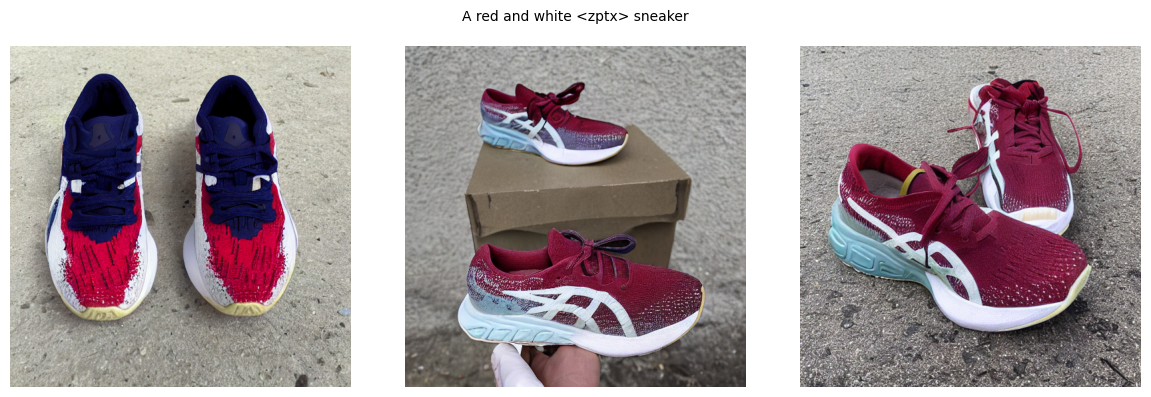

A digital ad for a <zptx> sneaker on a cloud. Urban, blurry background. High contrast, high detail, sunset lighting


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

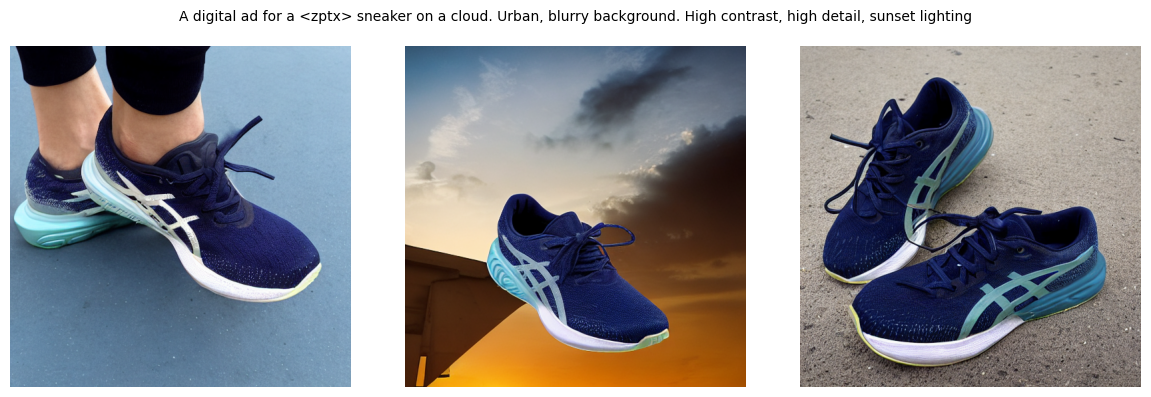

A digital advertisement featuring the <zptx> sneaker floating on a soft, realistic cloud. The sneaker is sharp, detailed, and well-lit with golden sunset lighting. Background is an urban cityscape, blurred to emphasize the shoe. High contrast, dramatic lighting, surreal but clean composition, modern ad style


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

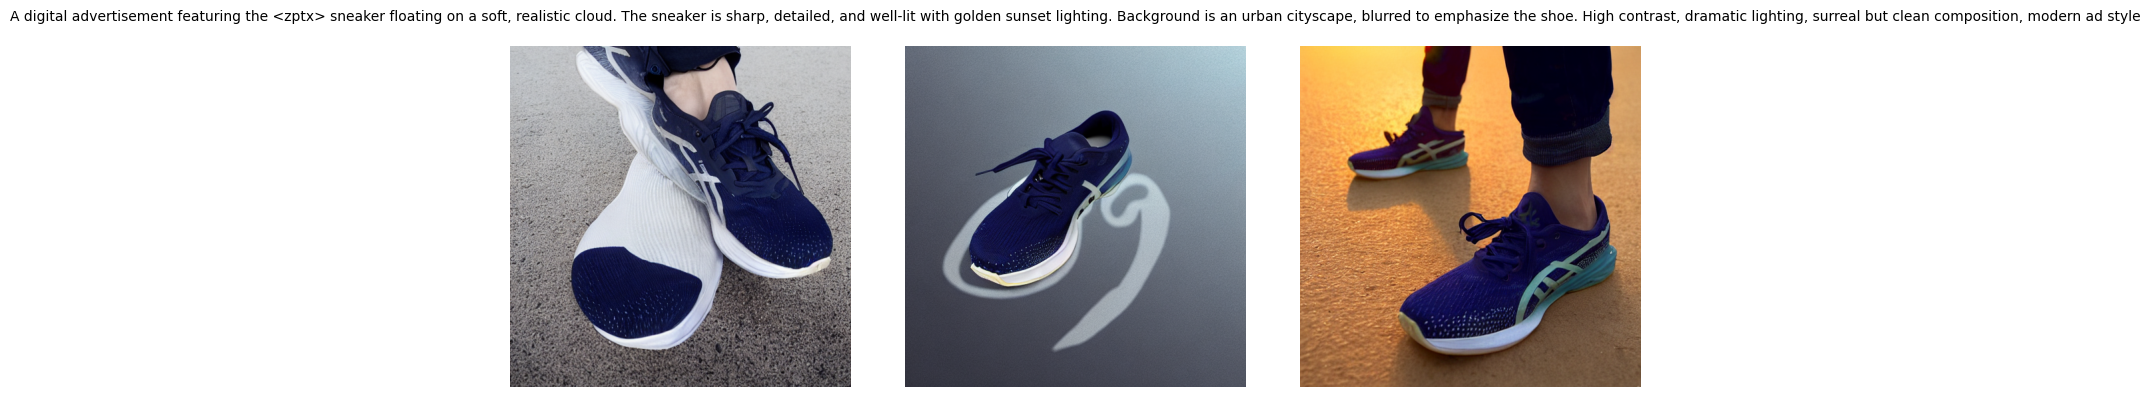

A digital eco-themed ad showing the <zptx> sneakers resting on a moss-covered rock in a futuristic forest, with soft morning light filtering through trees. High detail, green and silver tones, peaceful yet modern aesthetic


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

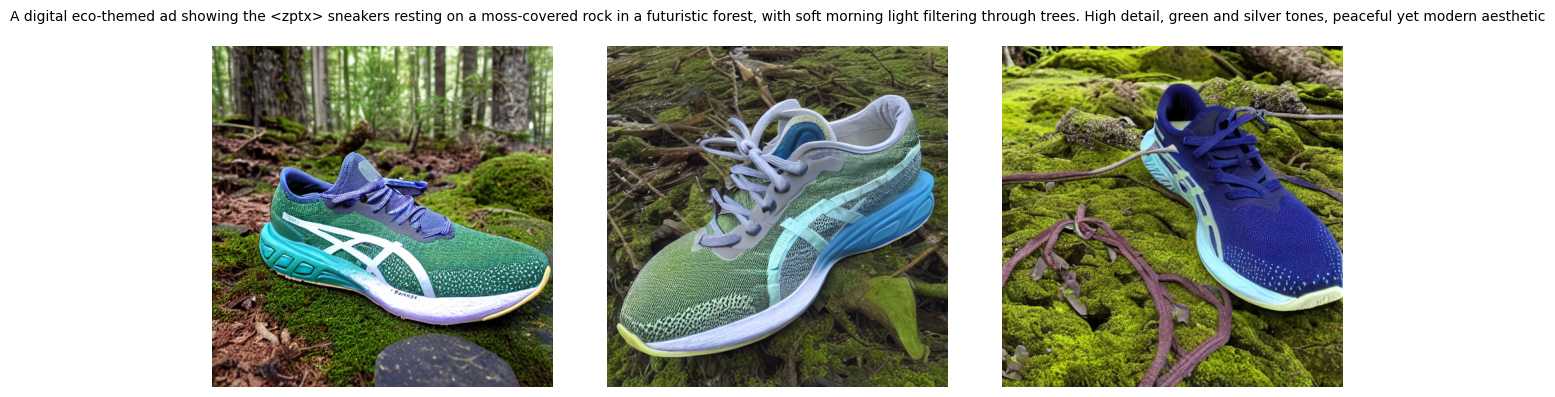

In [ ]:
import matplotlib.pyplot as plt

# Parámetros
n_repeats = 3
num_inference_steps = 40
guidance_scale = 6.5

# Iterar por cada prompt
for prompt in prompts:
    print(prompt)
    images = []

    # Generar 3 veces la imagen para el prompt
    for _ in range(n_repeats):
        image = pipe_lora(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
        images.append(image)

    # Mostrar las 3 imágenes juntas en una fila
    fig, axs = plt.subplots(1, n_repeats, figsize=(n_repeats * 4, 4))
    fig.suptitle(prompt, fontsize=10)

    for i in range(n_repeats):
        axs[i].imshow(images[i])
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Inferencia con Hugging Face:
from diffusers import StableDiffusionPipeline
import torch
# from peft import PeftModel  # o el método específico si usas LoRA con diffusers

pipe_rev = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

# Cargar LoRA usando compatibilidad con Diffusers:
pipe_rev.load_lora_weights("sgonzalezygil/sd-finetuning-lora-v2", weight_name="zapatillasLoRA-06.safetensors")
pipe_rev.fuse_lora()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

zapatillasLoRA-06.safetensors:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

A photo of <zptx> sneaker on the beach


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

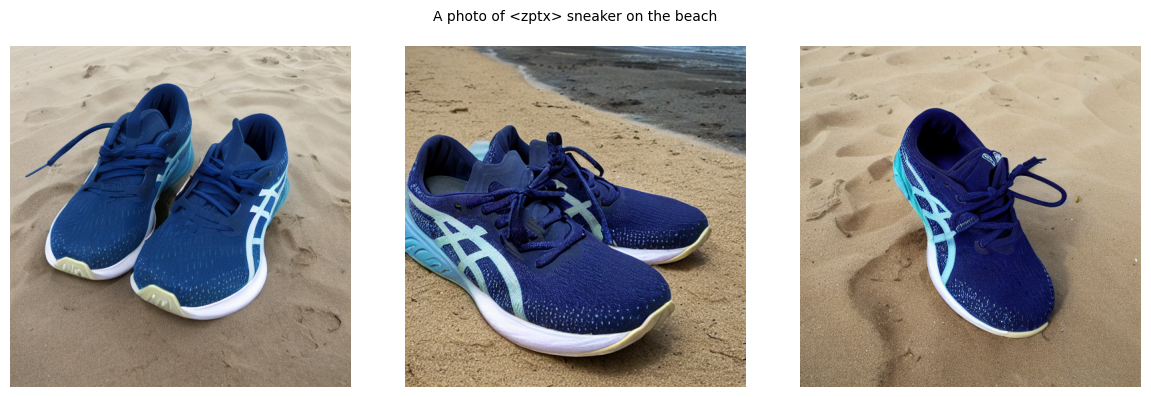

In [ ]:
import matplotlib.pyplot as plt

prompts = ["A photo of <zptx> sneaker on the beach"]
# Parámetros
n_repeats = 3
num_inference_steps = 40
guidance_scale = 6.5

# Iterar por cada prompt
for prompt in prompts:
    print(prompt)
    images = []

    # Generar 3 veces la imagen para el prompt
    for _ in range(n_repeats):
        image = pipe_rev(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
        images.append(image)

    # Mostrar las 3 imágenes juntas en una fila
    fig, axs = plt.subplots(1, n_repeats, figsize=(n_repeats * 4, 4))
    fig.suptitle(prompt, fontsize=10)

    for i in range(n_repeats):
        axs[i].imshow(images[i])
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# import nbformat

# notebook_path = "/content/drive/MyDrive/UNIR/TFM/DREAMB/sd_dreambooth_training.ipynb"
# nb = nbformat.read(notebook_path, as_version=nbformat.NO_CONVERT)

# if 'widgets' in nb['metadata']:
#     del nb['metadata']['widgets']

# nbformat.write(nb, notebook_path)